In [1]:
import random
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from BostonMech import BostonMechanism
from DA import DeferredAcceptance
import utils as utils


%load_ext autoreload
%autoreload 2

## Function Definition 

In [2]:
###############################################################################
# functions for plotting
###############################################################################


def dist_by_choice(DA_results, BM_results, CP_results, savename):
    # DA
    _, axs = plt.subplots(1, 2, figsize=(12, 3))
    res_DA_soph = utils.plot_frac_choice(
        DA_results,
        "sophisticated",
        n_iter,
        [
            axs[0],
            "Deferred Acceptance (Sophisticated)",
            "fraction of students",
            "ranking achieved",
            "darkblue",
            (0, 0.25),
        ],
    )
    res_DA_sinc = utils.plot_frac_choice(
        DA_results,
        "sincere",
        n_iter,
        [
            axs[1],
            "Deferred Acceptance (Sincere)",
            "fraction of students",
            "ranking achieved",
            "darkblue",
            (0, 0.25),
        ],
    )
    plt.savefig(f"../figures/DA_{savename}.png", bbox_inches="tight")

    # BM
    _, axs = plt.subplots(1, 2, figsize=(12, 3))
    res_BM_soph = utils.plot_frac_choice(
        BM_results,
        "sophisticated",
        n_iter,
        [
            axs[0],
            "Boston Mechanism (Sophisticated)",
            "fraction of students",
            "ranking achieved",
            "maroon",
            (0, 0.25),
        ],
    )
    res_BM_sinc = utils.plot_frac_choice(
        BM_results,
        "sincere",
        n_iter,
        [
            axs[1],
            "Boston Mechanism (Sincere)",
            "fraction of students",
            "ranking achieved",
            "maroon",
            (0, 0.25),
        ],
    )
    plt.savefig(f"../figures/BM_{savename}.png", bbox_inches="tight")

    # CP
    _, axs = plt.subplots(1, 2, figsize=(12, 3))
    res_CP_soph = utils.plot_frac_choice(
        CP_results,
        "sophisticated",
        n_iter,
        [
            axs[0],
            "Chinese Parallel Mechanism (Sophisticated)",
            "fraction of students",
            "ranking achieved",
            "darkorange",
            (0, 0.25),
        ],
    )
    res_CP_sinc = utils.plot_frac_choice(
        CP_results,
        "sincere",
        n_iter,
        [
            axs[1],
            "Chinese Parallel Mechanism (Sincere)",
            "fraction of students",
            "ranking achieved",
            "darkorange",
            (0, 0.25),
        ],
    )
    plt.savefig(f"../figures/CP_{savename}.png", bbox_inches="tight")

    print(
        "BM sophisticated:", [(i + 1, round(n, 2)) for i, n in enumerate(res_BM_soph)]
    )
    print("BM sincere:", [(i + 1, round(n, 2)) for i, n in enumerate(res_BM_sinc)])

    print(
        "CP sophisticated:", [(i + 1, round(n, 2)) for i, n in enumerate(res_CP_soph)]
    )
    print("CP sincere:", [(i + 1, round(n, 2)) for i, n in enumerate(res_CP_sinc)])


def bar_plot_ave_ranking(DA_results, BM_results, CP_results, savename):

    _, axs = plt.subplots(1, 2, figsize=(12, 3))
    utils.plot_results(
        [DA_results, BM_results, CP_results],
        n_iter,
        "ranking_ave",
        [
            "Average Ranking Achieved by Students",
            "average ranking",
            ["soph", "sinc", "soph", "sinc", "soph", "sinc"],
            False,
            axs[0],
        ],
        CP=True,
    )
    utils.plot_results(
        [DA_results, BM_results, CP_results],
        n_iter,
        "ranking_std",
        [
            "Standard Deviate of Ranking Achieved by Students",
            "standard deviation of rankings",
            ["soph", "sinc", "soph", "sinc", "soph", "sinc"],
            True,
            axs[1],
        ],
        CP=True,
    )

    plt.savefig(f"../figures/DABMCP_{savename}.png", bbox_inches="tight")


def dist_rank_change(rank_improvs_DA, rank_improvs_CP, soph_idx, savename):
    _, axs = plt.subplots(1, 1, figsize=(6, 3))

    pooled_rank = rank_improvs_DA[:, soph_idx].flatten()
    utils.plot_hist(
        pooled_rank,
        [
            axs,
            "From Bostom Mechanism to Deferred Acceptance",
            "fraction of students",
            "change in ranking",
            "sophisticated",
            "maroon",
            np.arange(-15.5, 16.5, 1),
        ],
    )
    pooled_rank = np.array(
        [
            rank_improvs_DA[:, idx]
            for idx in range(rank_improvs_DA.shape[1])
            if idx not in soph_idx
        ]
    ).flatten()
    utils.plot_hist(
        pooled_rank,
        [
            axs,
            "From Bostom Mechanism to Deferred Acceptance",
            "fraction of students",
            "change in ranking",
            "sincere",
            "darkblue",
            np.arange(-15.5, 16.5, 1),
        ],
    )
    plt.savefig(f"../figures/BM2DA_{savename}.png", bbox_inches="tight")

    _, axs = plt.subplots(1, 1, figsize=(6, 3))

    pooled_rank = rank_improvs_CP[:, soph_idx].flatten()
    utils.plot_hist(
        pooled_rank,
        [
            axs,
            "From Bostom Mechanism to Chinese Parallel",
            "fraction of students",
            "change in ranking",
            "sophisticated",
            "maroon",
            np.arange(-15.5, 16.5, 1),
        ],
    )
    pooled_rank = np.array(
        [
            rank_improvs_CP[:, idx]
            for idx in range(rank_improvs_CP.shape[1])
            if idx not in soph_idx
        ]
    ).flatten()
    utils.plot_hist(
        pooled_rank,
        [
            axs,
            "From Bostom Mechanism to Chinese Parallel",
            "fraction of students",
            "change in ranking",
            "sincere",
            "darkblue",
            np.arange(-15.5, 16.5, 1),
        ],
    )
    plt.savefig(f"../figures/BM2CP_{savename}.png", bbox_inches="tight")


###############################################################################
# Function to compute some statistics
###############################################################################
def frac_ppl_improve(rank_improvs_DA, rank_improvs_CP, soph_idx):
    rank_improvs_sinc = np.array(
        [
            rank_improvs_DA[:, idx]
            for idx in range(rank_improvs_DA.shape[1])
            if idx not in soph_idx
        ]
    ).T  # (ntrials, n_sinc)
    rank_improvs_soph = np.array(rank_improvs_DA[:, soph_idx])  # (ntrials, n_soph)

    rank_improv_frac_all = np.mean(np.mean(rank_improvs_DA < 0, axis=1))  # (ntrials,)
    rank_improv_frac_soph = np.mean(
        np.mean(rank_improvs_soph < 0, axis=1)
    )  # (ntrials,)
    rank_improv_frac_sinc = np.mean(
        np.mean(rank_improvs_sinc < 0, axis=1)
    )  # (ntrials,)

    print("Fraction of people who strictly improved their ranking in DA:")
    print("All:", rank_improv_frac_all)
    print("Sophisticated:", rank_improv_frac_soph)
    print("Sincere:", rank_improv_frac_sinc)
    print("------------------------------------------------------")

    rank_improvs_sinc = np.array(
        [
            rank_improvs_CP[:, idx]
            for idx in range(rank_improvs_CP.shape[1])
            if idx not in soph_idx
        ]
    ).T  # (ntrials, n_sinc)
    rank_improvs_soph = np.array(rank_improvs_CP[:, soph_idx])  # (ntrials, n_soph)

    rank_improv_frac_all = np.mean(np.mean(rank_improvs_CP < 0, axis=1))  # (ntrials,)
    rank_improv_frac_soph = np.mean(
        np.mean(rank_improvs_soph < 0, axis=1)
    )  # (ntrials,)
    rank_improv_frac_sinc = np.mean(
        np.mean(rank_improvs_sinc < 0, axis=1)
    )  # (ntrials,)

    print("Fraction of people who strictly improved their ranking in CP:")
    print("All:", rank_improv_frac_all)
    print("Sophisticated:", rank_improv_frac_soph)
    print("Sincere:", rank_improv_frac_sinc)
    print("------------------------------------------------------")

    
    rank_improvs_sinc = np.array(
        [
            rank_improvs_DA[:, idx]
            for idx in range(rank_improvs_DA.shape[1])
            if idx not in soph_idx
        ]
    ).T  # (ntrials, n_sinc)
    rank_improvs_soph = np.array(rank_improvs_DA[:, soph_idx])  # (ntrials, n_soph)

    rank_improv_frac_all = np.mean(np.mean(rank_improvs_DA <= 0, axis=1))  # (ntrials,)
    rank_improv_frac_soph = np.mean(
        np.mean(rank_improvs_soph <= 0, axis=1)
    )  # (ntrials,)
    rank_improv_frac_sinc = np.mean(
        np.mean(rank_improvs_sinc <= 0, axis=1)
    )  # (ntrials,)

    print("Fraction of people who weakly improved their ranking in DA:")
    print("All:", rank_improv_frac_all)
    print("Sophisticated:", rank_improv_frac_soph)
    print("Sincere:", rank_improv_frac_sinc)
    print("------------------------------------------------------")

    rank_improvs_sinc = np.array(
        [
            rank_improvs_CP[:, idx]
            for idx in range(rank_improvs_CP.shape[1])
            if idx not in soph_idx
        ]
    ).T  # (ntrials, n_sinc)
    rank_improvs_soph = np.array(rank_improvs_CP[:, soph_idx])  # (ntrials, n_soph)

    rank_improv_frac_all = np.mean(np.mean(rank_improvs_CP <= 0, axis=1))  # (ntrials,)
    rank_improv_frac_soph = np.mean(
        np.mean(rank_improvs_soph <= 0, axis=1)
    )  # (ntrials,)
    rank_improv_frac_sinc = np.mean(
        np.mean(rank_improvs_sinc <= 0, axis=1)
    )  # (ntrials,)

    print("Fraction of people who weakly improved their ranking in CP:")
    print("All:", rank_improv_frac_all)
    print("Sophisticated:", rank_improv_frac_soph)
    print("Sincere:", rank_improv_frac_sinc)
    print("------------------------------------------------------")

def ave_rank_change(rank_improvs_DA, rank_improvs_CP):
    n_ranking_dec = rank_improvs_DA.mean()
    print(
        f"On average, each student is worse off by {n_ranking_dec:.3f} rank switching to DA."
    )
    print("------------------------------------------------------")

    n_ranking_dec = rank_improvs_CP.mean()
    print(
        f"On average, each student is worse off by {n_ranking_dec:.3f} rank switching to CP."
    )
    print("------------------------------------------------------")


def count_blocking_pairs(n_blocks_DA, n_blocks_BM, n_blocks_CP):
    ave_nblocks = np.mean(n_blocks_DA)
    print(f"{ave_nblocks} blocking pairs in DA.")

    ave_nblocks = np.mean(n_blocks_BM)
    print(f"{ave_nblocks} blocking pairs in BM.")

    ave_nblocks = np.mean(n_blocks_CP)
    print(f"{ave_nblocks} blocking pairs in CP.")



## Fraction of Sophisticated Students = 0.2

In [3]:
perc_soph = 0.2
n_iter = 100
DA_results, BM_results, CP_results, rank_improvs_DA, rank_improvs_CP, n_blocks_DA, n_blocks_BM, n_blocks_CP, soph_idx = utils.simulation_wrapper(perc_soph, n_iter)

 79%|███████▉  | 79/100 [02:19<00:38,  1.81s/it]

BM sophisticated: [(1, 0.22), (2, 0.11), (3, 0.11), (4, 0.09), (5, 0.09), (6, 0.02), (7, 0.05), (8, 0.08), (9, 0.1), (10, 0.06), (11, 0.02), (12, 0.01), (13, 0.01), (14, 0.01), (15, 0.01), (16, 0.01), (17, 0.01)]
BM sincere: [(1, 0.22), (2, 0.03), (3, 0.06), (4, 0.11), (5, 0.07), (6, 0.03), (7, 0.06), (8, 0.1), (9, 0.14), (10, 0.09), (11, 0.02), (12, 0.01), (13, 0.01), (14, 0.01), (15, 0.01), (16, 0.01), (17, 0.01)]
CP sophisticated: [(1, 0.1), (2, 0.11), (3, 0.13), (4, 0.14), (5, 0.17), (6, 0.07), (7, 0.02), (8, 0.04), (9, 0.06), (10, 0.07), (11, 0.04), (12, 0.02), (13, 0.01), (14, 0.01), (15, 0.0), (16, 0.0), (17, 0.0)]
CP sincere: [(1, 0.1), (2, 0.11), (3, 0.13), (4, 0.02), (5, 0.05), (6, 0.1), (7, 0.03), (8, 0.06), (9, 0.1), (10, 0.13), (11, 0.08), (12, 0.04), (13, 0.02), (14, 0.01), (15, 0.01), (16, 0.01), (17, 0.01)]


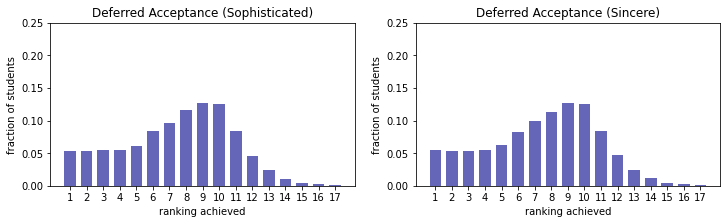

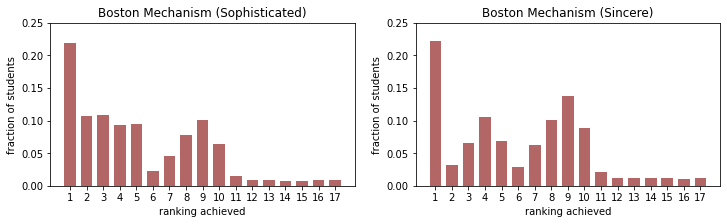

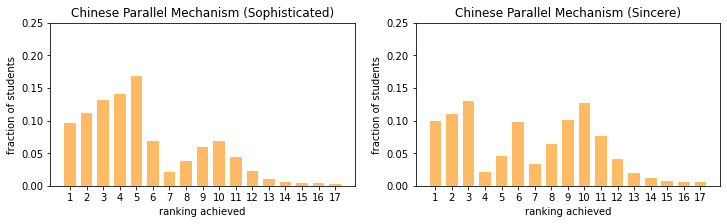

In [ ]:
dist_by_choice(DA_results, BM_results, CP_results, 'frac_choice_p2')

Average for DA: [0.         0.         0.         0.         6.43460106 6.43584881]
Average for BM: [4.15087766 5.01098806 0.         0.         0.         0.        ]
Average for CP: [0.         0.         4.3643883  5.62082228 0.         0.        ]
Standard Deviation for DA: [0.         0.         0.         0.         0.19077775 0.08555819]
Standard Deviation for BM: [0.19386268 0.0613509  0.         0.         0.         0.        ]
Standard Deviation for CP: [0.         0.         0.19144817 0.08728483 0.         0.        ]
Average for DA: [0.         0.         0.         0.         3.30998757 3.32697848]
Average for BM: [3.7904288  3.98845217 0.         0.         0.         0.        ]
Average for CP: [0.         0.         3.37257136 3.93327749 0.         0.        ]
Standard Deviation for DA: [0.         0.         0.         0.         0.1171949  0.05796121]
Standard Deviation for BM: [0.14799917 0.05279871 0.         0.         0.         0.        ]
Standard Deviation fo

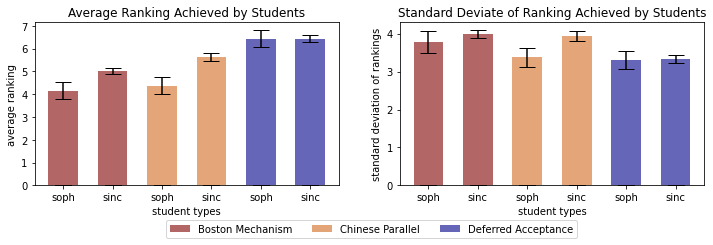

In [ ]:
bar_plot_ave_ranking(DA_results, BM_results, CP_results, 'rank_ave_std_p2')

(min, max): (-15.0, 16.0)
(min, max): (-15.0, 16.0)
(min, max): (-15.0, 15.0)
(min, max): (-15.0, 16.0)


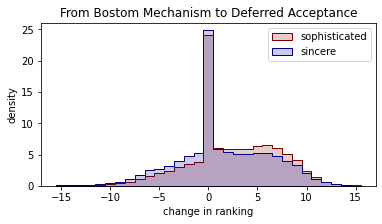

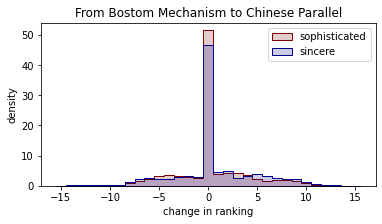

In [ ]:
dist_rank_change(rank_improvs_DA, rank_improvs_CP, soph_idx, 'rank_change_hist_p2')

In [ ]:
frac_ppl_improve(rank_improvs_DA, rank_improvs_CP, soph_idx)
ave_rank_change(rank_improvs_DA, rank_improvs_CP)
count_blocking_pairs(n_blocks_DA, n_blocks_BM, n_blocks_CP)

Fraction of people who strictly improved their ranking in DA:
All: 0.25431528662420383
Sophisticated: 0.19359042553191488
Sincere: 0.2694562334217506
------------------------------------------------------
Fraction of people who strictly improved their ranking in CP:
All: 0.2144002123142251
Sophisticated: 0.2170212765957447
Sincere: 0.21374668435013264
------------------------------------------------------
Fraction of people who weakly improved their ranking in DA:
All: 0.5010350318471338
Sophisticated: 0.4342553191489362
Sincere: 0.517685676392573
------------------------------------------------------
Fraction of people who weakly improved their ranking in CP:
All: 0.6901751592356689
Sophisticated: 0.7319946808510639
Sincere: 0.6797480106100795
------------------------------------------------------
On average, each student is worse off by 1.596 rank switching to DA.
------------------------------------------------------
On average, each student is worse off by 0.531 rank switching to C

(min, max): (3775, 4132)
(min, max): (3125, 3875)


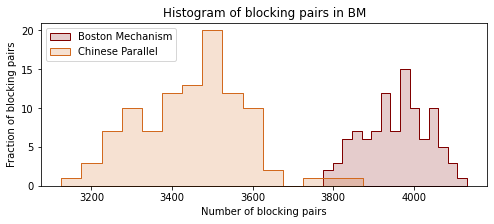

In [ ]:
_, axs = plt.subplots(1, 1, figsize=(8, 3))
utils.plot_hist(n_blocks_BM, plot_related=[
    axs,
    "Histogram of blocking pairs in BM",
    "fraction of blocking pairs",
    "number of blocking pairs",
    "Boston Mechanism",
    "maroon",
    15], legend_pos='upper left')
utils.plot_hist(n_blocks_CP, plot_related=[
    axs,
    "Distribution of blocking pairs in BM",
    "fraction of students",
    "number of blocking pairs",
    "Chinese Parallel",
    "chocolate",
    15], legend_pos='upper left')
plt.savefig('../figures/blocking_pairs_hist_p2.png', bbox_inches='tight')

## Fraction of Sophisticated Students = 0.8

In [ ]:
perc_soph = 0.8
n_iter = 100
DA_results, BM_results, CP_results, rank_improvs_DA, rank_improvs_CP, n_blocks_DA, n_blocks_BM, n_blocks_CP, soph_idx = utils.simulation_wrapper(perc_soph, n_iter)

100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


BM sophisticated: [(1, 0.17), (2, 0.09), (3, 0.1), (4, 0.09), (5, 0.09), (6, 0.03), (7, 0.06), (8, 0.09), (9, 0.12), (10, 0.08), (11, 0.02), (12, 0.01), (13, 0.01), (14, 0.01), (15, 0.01), (16, 0.01), (17, 0.01)]
BM sincere: [(1, 0.17), (2, 0.03), (3, 0.06), (4, 0.1), (5, 0.05), (6, 0.03), (7, 0.07), (8, 0.12), (9, 0.16), (10, 0.1), (11, 0.02), (12, 0.01), (13, 0.01), (14, 0.01), (15, 0.01), (16, 0.01), (17, 0.01)]
CP sophisticated: [(1, 0.08), (2, 0.1), (3, 0.12), (4, 0.12), (5, 0.14), (6, 0.04), (7, 0.03), (8, 0.06), (9, 0.09), (10, 0.11), (11, 0.06), (12, 0.03), (13, 0.02), (14, 0.01), (15, 0.01), (16, 0.01), (17, 0.01)]
CP sincere: [(1, 0.08), (2, 0.1), (3, 0.12), (4, 0.01), (5, 0.02), (6, 0.04), (7, 0.04), (8, 0.09), (9, 0.13), (10, 0.17), (11, 0.09), (12, 0.04), (13, 0.02), (14, 0.01), (15, 0.01), (16, 0.01), (17, 0.01)]


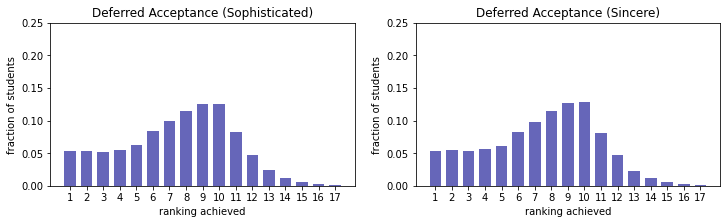

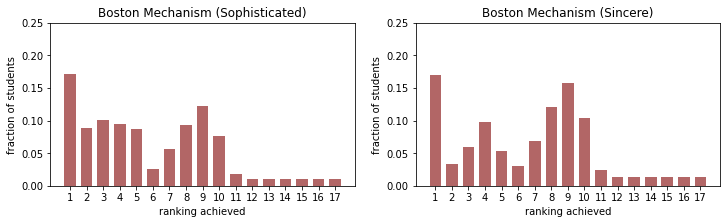

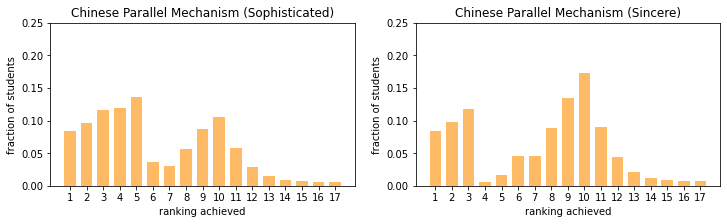

In [ ]:
dist_by_choice(DA_results, BM_results, CP_results, 'frac_choice_p8')

Average for DA: [0.         0.         0.         0.         6.43921699 6.42782493]
Average for BM: [4.75591904 5.58647215 0.         0.         0.         0.        ]
Average for CP: [0.         0.         5.13825481 6.32246684 0.         0.        ]
Standard Deviation for DA: [0.         0.         0.         0.         0.08219918 0.16747772]
Standard Deviation for BM: [0.05349313 0.18336857 0.         0.         0.         0.        ]
Standard Deviation for CP: [0.         0.         0.0685837  0.20354258 0.         0.        ]
Average for DA: [0.         0.         0.         0.         3.32080953 3.32518576]
Average for BM: [3.86748576 3.96023517 0.         0.         0.         0.        ]
Average for CP: [0.         0.         3.71408766 3.92419827 0.         0.        ]
Standard Deviation for DA: [0.         0.         0.         0.         0.0599801  0.10086347]
Standard Deviation for BM: [0.05091162 0.12895565 0.         0.         0.         0.        ]
Standard Deviation fo

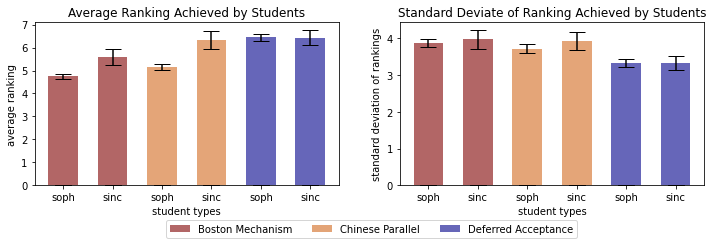

In [ ]:
bar_plot_ave_ranking(DA_results, BM_results, CP_results, 'rank_ave_std_p8')

(min, max): (-15.0, 16.0)
(min, max): (-15.0, 16.0)
(min, max): (-15.0, 16.0)
(min, max): (-15.0, 16.0)


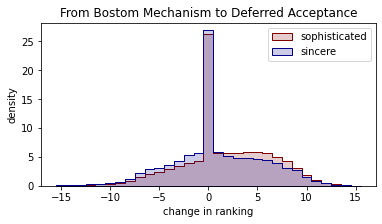

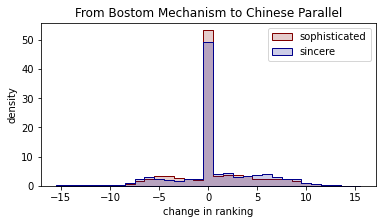

In [ ]:
dist_rank_change(rank_improvs_DA, rank_improvs_CP, soph_idx, 'rank_change_hist_p8')

In [ ]:
frac_ppl_improve(rank_improvs_DA, rank_improvs_CP, soph_idx)
ave_rank_change(rank_improvs_DA, rank_improvs_CP)
count_blocking_pairs(n_blocks_DA, n_blocks_BM, n_blocks_CP)

Fraction of people who strictly improved their ranking in DA:
All: 0.24453290870488328
Sophisticated: 0.2291838088918381
Sincere: 0.30588859416445624
------------------------------------------------------
Fraction of people who strictly improved their ranking in CP:
All: 0.1960191082802548
Sophisticated: 0.1990643662906437
Sincere: 0.1838461538461538
------------------------------------------------------
Fraction of people who weakly improved their ranking in DA:
All: 0.5082590233545649
Sophisticated: 0.49165228931652294
Sincere: 0.5746419098143236
------------------------------------------------------
Fraction of people who weakly improved their ranking in CP:
All: 0.7190021231422505
Sophisticated: 0.7300066357000664
Sincere: 0.6750132625994695
------------------------------------------------------
On average, each student is worse off by 1.515 rank switching to DA.
------------------------------------------------------
On average, each student is worse off by 0.453 rank switching to 

In [ ]:
def plot_hist(to_plot, plot_related):
    print("(min, max):", (to_plot.min(), to_plot.max()))
    canvas = plot_related[0]
    plot_title = plot_related[1]
    plot_y_label = plot_related[2]
    plot_x_label = plot_related[3]
    plot_label = plot_related[4]
    plot_color = plot_related[5]
    plot_bins = plot_related[6]

    sns.histplot(
        to_plot,
        color=plot_color,
        stat="percent",
        bins=plot_bins,
        element="step",
        alpha=0.2,
        label=plot_label,
    )
    canvas.set(title=plot_title, ylabel=plot_y_label, xlabel=plot_x_label)
    canvas.legend()


(min, max): (3479, 3842)
(min, max): (2334, 3227)


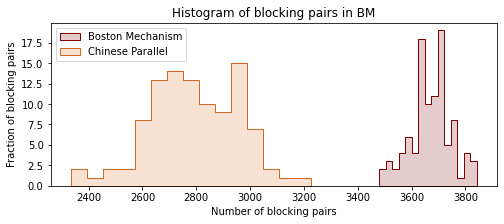

In [ ]:
_, axs = plt.subplots(1, 1, figsize=(8, 3))
utils.plot_hist(n_blocks_BM, plot_related=[
    axs,
    "Histogram of blocking pairs in BM",
    "fraction of blocking pairs",
    "number of blocking pairs",
    "Boston Mechanism",
    "maroon",
    15], legend_pos='upper left')
utils.plot_hist(n_blocks_CP, plot_related=[
    axs,
    "Distribution of blocking pairs in BM (80% Sophisticated)",
    "fraction of students",
    "number of blocking pairs",
    "Chinese Parallel",
    "chocolate",
    15], legend_pos='upper left')
plt.savefig('../figures/blocking_pairs_hist_p8.png', bbox_inches='tight'))